In [16]:
import numpy as np
import torch

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors 
from physynthtrainer import densityModel, plasmaFreq, freqDrift
import numpy as np
from scipy.interpolate import RectBivariateSpline
import matplotlib.pyplot as plt

from PIL import Image

# reload actively
%load_ext autoreload
%autoreload 2

Create synthetic data for yolo training

Data description
* size: 640x640
* freq range: 24 to 88 MHz
* time cadence: every one sec per pix

In [5]:
from physynthtrainer.burstGen import generate_quasi_periodic_signal,biGaussian

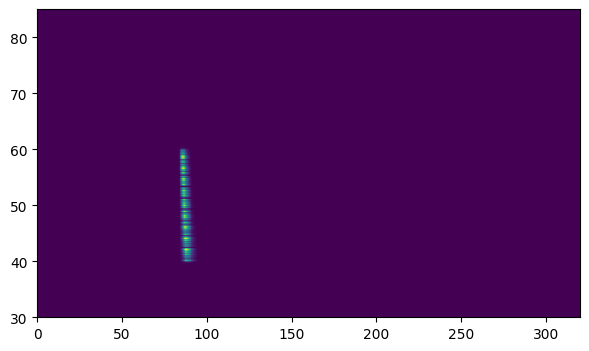

In [ ]:
# create single burst with deterministic parameters


freq_range = [30, 85] # MHz
t_res  =  0.5 # sec
t_start  =  0.0 # sec
N_freq = 640
N_time = 640

# create a radio burst type III
v_beam = 0.15# c
t0_burst = 80.0 # sec
decay_t_dur_100Mhz = 1 # sec
Burst_intensity = 1.0
burststarting_freq = 40.0
burstending_freq = 60.0
edge_freq_ratio = 0.01
fine_structure = True


img_bursts  = np.zeros((N_time, N_freq))
t_ax = t_start + np.arange(0, N_time) * t_res
f_ax = np.linspace(freq_range[0], freq_range[1], N_freq)

edge_freq = (burstending_freq - burststarting_freq) * edge_freq_ratio

t_burst = []

if fine_structure:
    freq_modulation = generate_quasi_periodic_signal(t_arr=f_ax, base_freq=0.5, num_harmonics=5, noise_level=0, freqvar=0.1)
    # normalize to 0-1
    freq_modulation = (freq_modulation - np.min(freq_modulation)) / (np.max(freq_modulation) - np.min(freq_modulation))

for pix_f, f_this in enumerate(f_ax):
    t_burst.append(freqDrift.freq_drift_t_f(f_ax[pix_f], v_beam, t0_burst))
    decay_t_dur_this = decay_t_dur_100Mhz * (100.0/f_this)
    burst_amp = Burst_intensity * (np.tanh((f_this - burststarting_freq) / edge_freq)+1) * (np.tanh((burstending_freq - f_this) / edge_freq)+1)
    burst_amp = burst_amp * freq_modulation[pix_f] if fine_structure  else burst_amp
    l_curve = biGaussian(t_ax, t_burst[-1], decay_t_dur_this, decay_t_dur_this/2, burst_amp)
    pix_t = np.argmin(np.abs(t_ax - t_burst[-1]))
    img_bursts[:, pix_f] += l_curve



t_burst = np.array(t_burst)

plt.figure(figsize=(7, 4), dpi=100)
plt.imshow(img_bursts.T, interpolation='nearest', aspect='auto', origin='lower', 
    extent=[t_start, t_start + N_time * t_res, freq_range[0], freq_range[1]])

#plt.xlim([0 , 200])

In [ ]:
# mask and bbox


from physynthtrainer.burstGen import generate_type_iii_burst
img_bursts, mask, bbox = generate_type_iii_burst(freq_range=[30, 85], t_res=0.5, t_start=0.0, N_freq=640, N_time=640,
                           v_beam=0.15, t0_burst=80.0, decay_t_dur_100Mhz=1.0,
                           Burst_intensity=1.0, burststarting_freq=40.0,
                           burstending_freq=60.0, edge_freq_ratio=0.05,
                           fine_structure=True)

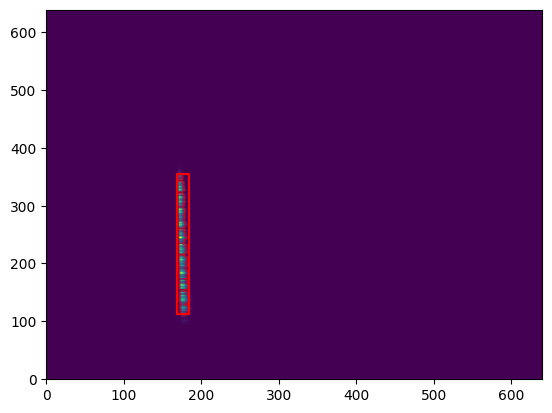

In [10]:
plt.imshow(img_bursts.T, interpolation='nearest', aspect='auto', origin='lower')

# plot mask and bbox
plt.contour(mask.T, levels=[0.5], colors='r', alpha=0.5)

# Convert YOLO bbox to matplotlib format
img_height, img_width = mask.shape
x_center, y_center, width, height = bbox

xmin = int((x_center - width / 2) * img_width)
xmax = int((x_center + width / 2) * img_width)
ymin = int((y_center - height / 2) * img_height)
ymax = int((y_center + height / 2) * img_height)

plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], 'r-')

In [73]:
# many type III bursts

from physynthtrainer.burstGen import generate_many_random_t3_bursts, create_radio_burst_hash_table

#t_burst_hash, f_ax, v_ax = create_radio_burst_hash_table(freq_range=[30, 85], N_freq=640, v_range=[0.05, 0.5], N_v=200)
img_bursts, bursts, is_t3b = generate_many_random_t3_bursts(n_bursts=30, use_hash_table=True, freq_range=[35, 80],
                hash_table=t_burst_hash, v_hash=v_ax)


Text(0, 0.5, 'Frequency (MHz)')

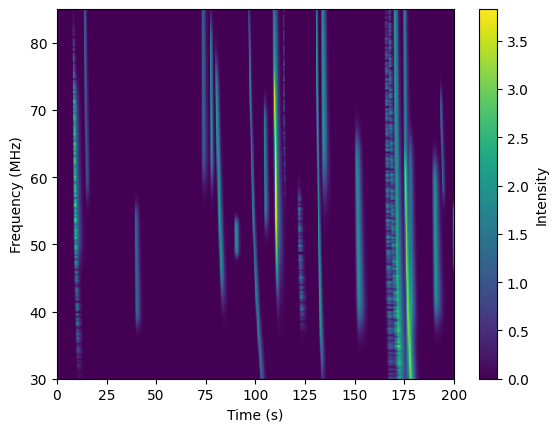

In [74]:
plt.imshow(img_bursts.T, interpolation='nearest', aspect='auto', origin='lower',
           extent=[0, 200, 30, 85])
plt.colorbar(label='Intensity')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (MHz)')

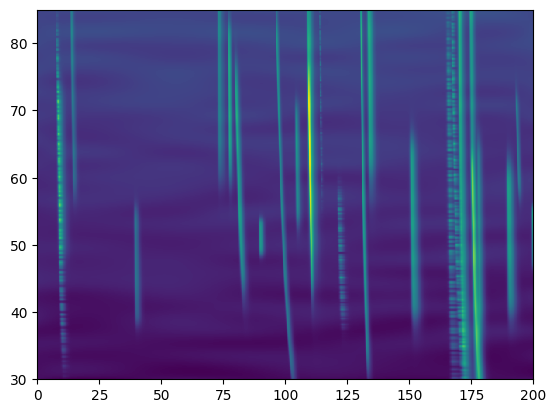

In [75]:
from physynthtrainer.burstGen import added_noise


noise_bg = added_noise(t_ax, f_ax, noise_size=[32,8], noise_level=0.35)

y = np.linspace(0.1, 1, 640)
const_bg = np.tile(y[:, np.newaxis], (1, 640))

img_bursts_noisy = img_bursts + noise_bg.T+ const_bg.T
plt.imshow(img_bursts_noisy.T, interpolation='nearest', aspect='auto', origin='lower',
           extent=[0, 200, 30, 85])

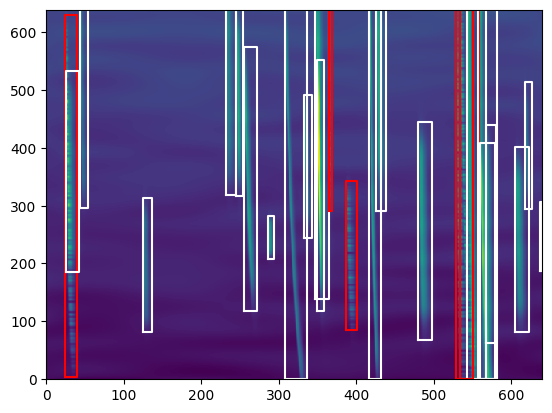

In [76]:
plt.imshow(img_bursts_noisy.T, interpolation='nearest', aspect='auto', origin='lower')


for bbox,label_t3 in zip(bursts, is_t3b):
    x_center, y_center, width, height = bbox
    xmin = int((x_center - width / 2) * img_width)
    xmax = int((x_center + width / 2) * img_width)
    ymin = int((y_center - height / 2) * img_height)
    ymax = int((y_center + height / 2) * img_height)

    if label_t3:
        plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], 'r-')
    else:
        plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], 'w-')